In [4]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace
from torch.autograd import Variable
     
    
args = {
      'ckptpath': './checkpoint.pth',
      'dataset_dir': './food/'
}
args = argparse.Namespace(**args)

In [5]:
# Model definition
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        def building_block(indim, outdim):
            return [
        nn.Conv2d(indim, outdim, 3, 1, 1),
        nn.BatchNorm2d(outdim),
        nn.ReLU(),
      ]
        def stack_blocks(indim, outdim, block_num):
            layers = building_block(indim, outdim)
            for i in range(block_num - 1):
                layers += building_block(outdim, outdim)
            layers.append(nn.MaxPool2d(2, 2, 0))
            return layers
        
        cnn_list = []
        cnn_list += stack_blocks(3, 128, 3)
        cnn_list += stack_blocks(128, 128, 3)
        cnn_list += stack_blocks(128, 256, 3)
        cnn_list += stack_blocks(256, 512, 1)
        cnn_list += stack_blocks(512, 512, 1)
        self.cnn = nn.Sequential( * cnn_list)

        dnn_list = [
      nn.Linear(512 * 4 * 4, 1024),
      nn.ReLU(),
      nn.Dropout(p = 0.3),
      nn.Linear(1024, 11),
    ]
        self.fc = nn.Sequential( * dnn_list)

    def forward(self, x):
        out = self.cnn(x)
        out = out.reshape(out.size()[0], -1)
        return self.fc(out)
     

# Load trained model
model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [6]:
# It might take some time, if it is too long, try to reload it.
# Dataset definition
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        # mode: 'train' or 'eval'
        
        self.paths = paths
        self.labels = labels
        trainTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        evalTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
        ])
        self.transform = trainTransform if mode == 'train' else evalTransform

    # pytorch dataset class
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

    # help to get images for visualizing
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images), torch.tensor(labels)

# help to get data path and label
def get_paths_labels(path):
    def my_key(name):
        return int(name.replace(".jpg",""))+1000000*int(name.split("_")[0])
    imgnames = os.listdir(path)
    imgnames.sort(key=my_key)
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    return imgpaths, labels
train_paths, train_labels = get_paths_labels(args.dataset_dir)

train_set = FoodDataset(train_paths, train_labels, mode='eval')

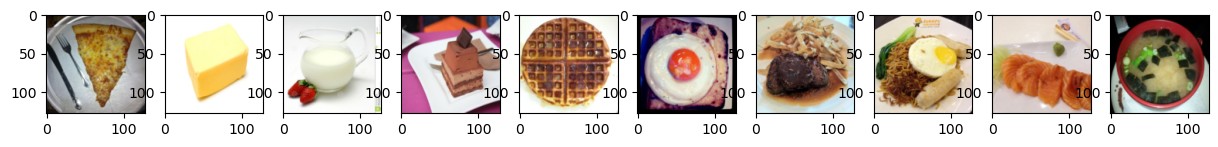

In [7]:
img_indices = [i for i in range(10)]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
    axs[i].imshow(img.cpu().permute(1, 2, 0))
# print(labels)

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


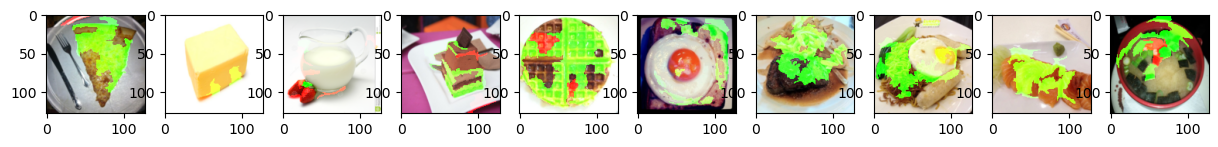

In [8]:
#lime
def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    
    model.eval()                                                                                                                                                             
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
    # pytorch tensor, (batches, channels, height, width)

    output = model(input.cuda())                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):
    # split the image into 200 pieces with the help of segmentaion from skimage                                                                                                                   
    return slic(input, n_segments=200, compactness=1, sigma=1)                                                                                                              
                                                                                                                                                                             

fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))                                                                                                                                                                 
# fix the random seed to make it reproducible
np.random.seed(16)                                                                                                                                                       
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):                                                                                                                                             
    x = image.astype(np.double)
    # numpy array for lime

    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)

    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.05                                                                                                                              
                            )
    # turn the result from explainer to the image
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    
    axs[idx].imshow(lime_img)

plt.show()
plt.close()

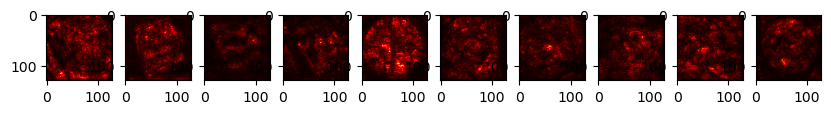

In [8]:
import torchvision
import matplotlib.pyplot as plt

#saliency map

#images[10,3,128,128]
#labels[10]
def normalize(image):
    return (image-image.min())/(image.max()-image.min())

criterion=torch.nn.CrossEntropyLoss()
saliencies=[]
saliencies_1=[]
for i in range(images.shape[0]):
    im=images[i].detach().to('cuda')
    im=torch.unsqueeze(im,dim=0)
    im.requires_grad_()
    output=model(im)
    loss=criterion(output,torch.unsqueeze(labels[i],dim=0).to('cuda'))
    loss.backward()
    
    #取三个通道中的最大值
    saliency,_=torch.max(im.grad.data.cpu().abs(),dim=1)
    #saliency_shape[1,3,128,128]
    saliency=im.grad.data.cpu().abs()
    saliency,_=torch.max(saliency,dim=1)
    #saliency_shape[1,128,128]
    saliencies.append(normalize(saliency))
    
plt.figure(figsize=(10,15))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(saliencies[i].permute(1,2,0),cmap=plt.cm.hot)
plt.show()
plt.close()



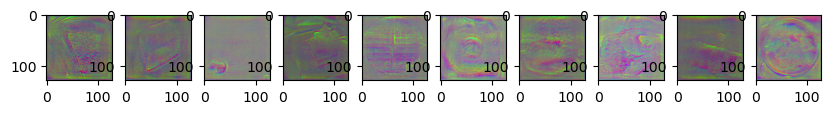

In [12]:
#Smooth Grad
#noise_level=sigma/(max(X)-min(X))
noise_level=0.4
epoch=500

grad_list=[]
for i in range(10):
    im=images[i].detach()
    label=labels[i]
    sigma=noise_level*(torch.max(im)-torch.min(im)).item()
    
    grad=torch.zeros_like(im)
    for i in range(500):
        #noise~N(0,1)
        noise=torch.randn_like(im)
        #noise~N(0,sigma^2)
        noise=noise*sigma
        #add noise
        
        im_m=torch.unsqueeze((im+noise),dim=0).to('cuda')
        im_m.requires_grad_()
        output=model(im_m)
        criterion=torch.nn.CrossEntropyLoss()
        loss=criterion(output,torch.unsqueeze(label,dim=0).to('cuda'))
        loss.backward()
        grad+=torch.squeeze(im_m.grad.data.cpu(),dim=0)
        
    grad_list.append(grad/epoch)


plt.figure(figsize=(10,15))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(normalize(grad_list[i]).permute(1,2,0))
plt.show()
plt.close()

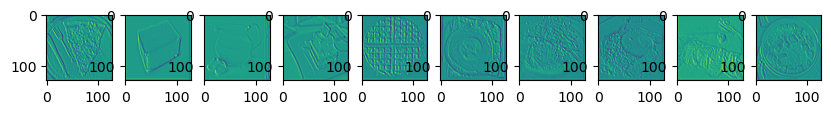

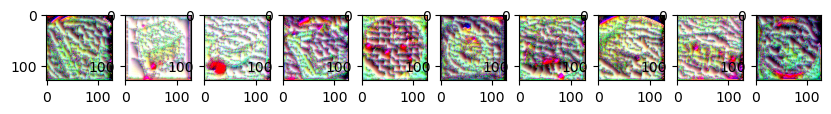

In [34]:
#filter visualization
filter_activation=[]
filter_visualization=[]
filter_output=None
def filter_visiualize(model,image,epoch,layer_id,filter_id):
    global filter_activation
    global filter_visualization
    global filter_output_sum
    im=image.detach()
    im=torch.unsqueeze(im,dim=0).to('cuda')
    
    def hook(model,inp,out):
        global filter_output
        filter_output=torch.squeeze(out[:,filter_id,:,:],dim=0)
    hook_handle=model.cnn[layer_id].register_forward_hook(hook)
    o=model(im)
    filter_activation.append(filter_output) 
    x=im.detach().to('cuda')
    x.requires_grad_()
    optimizer=torch.optim.Adam([x],lr=0.1)
    for i in range(epoch):
        optimizer.zero_grad()
        model(x)
        loss=-filter_output.sum()
        loss.backward()
        optimizer.step()
    filter_visualization.append(x)
    hook_handle.remove()  

for i in range(10):
    filter_visiualize(model,images[i],100,6,0)
plt.figure(figsize=(10,15))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(filter_activation[i].cpu().detach().numpy())
plt.show()
plt.close()

plt.figure(figsize=(10,15))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(torch.squeeze(filter_visualization[i].cpu(),dim=0).detach().permute(1,2,0))
plt.show()
plt.close()

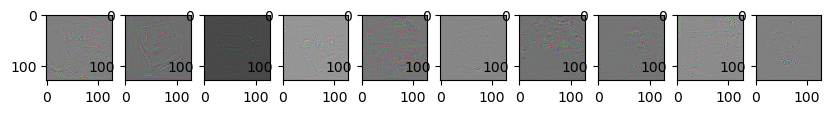

In [15]:
#integrated gradients
def integrated_gradient(im,steps,model,label):
    im_0=torch.zeros_like(im)
    for i in range(1,11):
        im.requires_grad_()
        inp=im*i/steps
        inp=torch.unsqueeze(inp,dim=0).to('cuda')
        output=model(inp)
        output[:,label].backward()
        im_0+=torch.squeeze(im.grad,dim=0).cpu()
    return im_0/steps*im.detach()

gradients=[]
for i in range(10):
    image=images[i].detach()
    gradients.append(integrated_gradient(image,10,model,labels[i]))

plt.figure(figsize=(10,15))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(normalize(gradients[i]).permute(1,2,0))
plt.show()                                                              

In [2]:
!pip install transformers==4.5.0

import numpy as np
import random
import torch

from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from transformers import BertModel, BertTokenizerFast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 57.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=a0cac4e746e2ed1f775c93ea5ca15dd07ea4948027d89717dd753ec99a56b8b5
  Stored in directory: /root/.cache/pip/wheels/5b/e0/77/05245143a5b31f65af6a21f7afd3219e9fa4896f918af45677
Successfully built sacremoses
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.2
    Uninstalling tokenizers-0.13.2:
      Successfully uninstalled tokenizers-0.13.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.26.1
    Uninstalling transformers-4.26.1:
      Successfully uninstalled transformers-4.26.1


In [18]:
model = BertModel.from_pretrained('bert-base-chinese', output_hidden_states=True).eval()
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [21]:
# Sentences for visualization
sentences = []
sentences += ["今天买了苹果来吃"]
sentences += ["进口苹果（富士）平均每公斤下跌12.3%"]
sentences += ["苹果茶真难喝"]
sentences += ["老号都知道智利的苹果季节即将到来"]
sentences += ["进口苹果因防止水分流失故添加人工果糖"]
sentences += ["苹果即将于下月发出新款iPhone"]
sentences += ["苹果发新Face ID专利"]
sentences += ["今天买了苹果手机"]
sentences += ["苹果的股价又跌了"]
sentences += ["苹果押宝指纹辨识技术"]

# Index of word selected for embedding comparison. E.g. For sentence "蘋果茶真難喝", if index is 0, "蘋 is selected"
select_word_index = [4, 2, 0, 8, 2, 0, 0, 4, 0, 0]

In [19]:
import torch

def euclidean_distance(a,b):
    return torch.sqrt(torch.sum(torch.square(a-b))).item()



def cosine_similarity(a,b):
    c=torch.sum(a*b)
    euc_a=torch.sqrt(torch.sum(torch.square(a)))
    euc_b=torch.sqrt(torch.sum(torch.square(b)))
    return c/euc_a/euc_b.item()

a=torch.tensor([1,2,3])
b=torch.tensor([2,3,4])

print(cosine_similarity(a,b))

tensor(0.9926)


13
tensor([[ 0.0000, 11.9069, 22.7999, 13.7308, 11.8224, 24.7244, 22.1603, 15.6380,
         18.1648, 20.6725],
        [11.9069,  0.0000, 23.2956, 12.9697,  9.3107, 23.9037, 21.4164, 16.3791,
         17.3884, 19.6604],
        [22.7999, 23.2956,  0.0000, 22.3866, 20.9906, 11.5991, 11.7650, 26.6548,
         18.5833, 17.8643],
        [13.7308, 12.9697, 22.3866,  0.0000, 13.0835, 22.8047, 20.0457, 14.8986,
         16.1000, 17.7876],
        [11.8224,  9.3107, 20.9906, 13.0835,  0.0000, 22.8713, 19.9814, 18.3970,
         17.3849, 18.6884],
        [24.7244, 23.9037, 11.5991, 22.8047, 22.8713,  0.0000,  8.4298, 25.0167,
         15.3337, 13.7304],
        [22.1603, 21.4164, 11.7650, 20.0457, 19.9814,  8.4298,  0.0000, 23.2155,
         12.3795, 11.0283],
        [15.6380, 16.3791, 26.6548, 14.8986, 18.3970, 25.0167, 23.2155,  0.0000,
         16.8731, 19.5078],
        [18.1648, 17.3884, 18.5833, 16.1000, 17.3849, 15.3337, 12.3795, 16.8731,
          0.0000,  9.3386],
        [20.6725

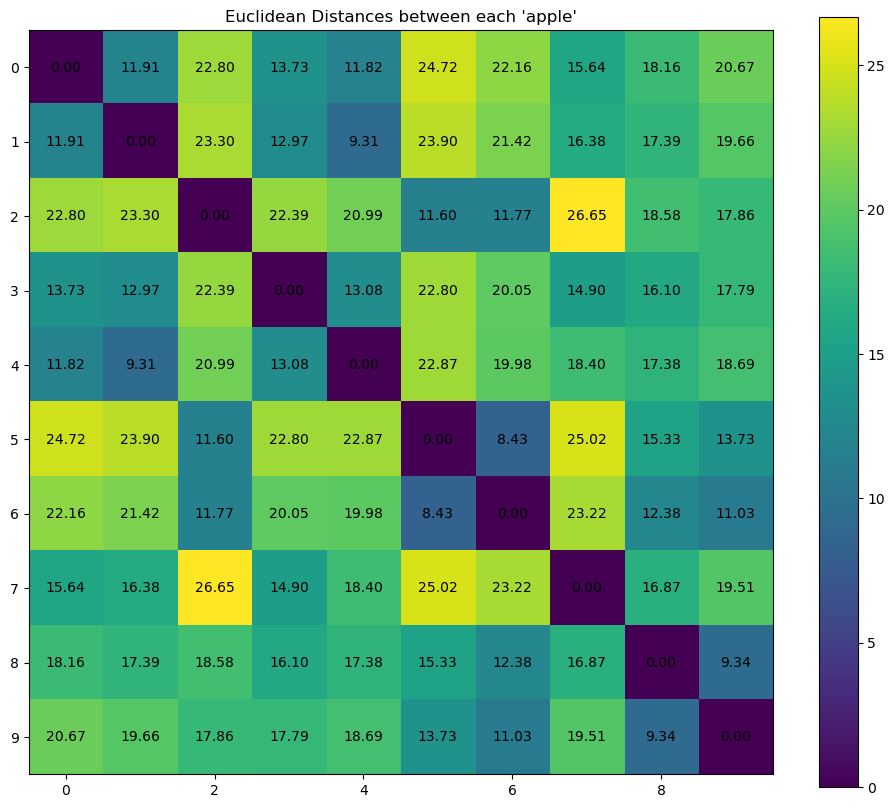

tensor([[1.0000, 0.8527, 0.4491, 0.8018, 0.8523, 0.3574, 0.4714, 0.7566, 0.6393,
         0.5391],
        [0.8527, 1.0000, 0.4296, 0.8247, 0.9093, 0.4043, 0.5106, 0.7347, 0.6726,
         0.5868],
        [0.4491, 0.4296, 1.0000, 0.4671, 0.5289, 0.8569, 0.8493, 0.2830, 0.6175,
         0.6516],
        [0.8018, 0.8247, 0.4671, 1.0000, 0.8185, 0.4515, 0.5660, 0.7786, 0.7158,
         0.6577],
        [0.8523, 0.9093, 0.5289, 0.8185, 1.0000, 0.4454, 0.5664, 0.6602, 0.6665,
         0.6200],
        [0.3574, 0.4043, 0.8569, 0.4515, 0.4454, 1.0000, 0.9235, 0.3734, 0.7422,
         0.7962],
        [0.4714, 0.5106, 0.8493, 0.5660, 0.5664, 0.9235, 1.0000, 0.4487, 0.8274,
         0.8650],
        [0.7566, 0.7347, 0.2830, 0.7786, 0.6602, 0.3734, 0.4487, 1.0000, 0.7064,
         0.6109],
        [0.6393, 0.6726, 0.6175, 0.7158, 0.6665, 0.7422, 0.8274, 0.7064, 1.0000,
         0.9016],
        [0.5391, 0.5868, 0.6516, 0.6577, 0.6200, 0.7962, 0.8650, 0.6109, 0.9016,
         1.0000]])


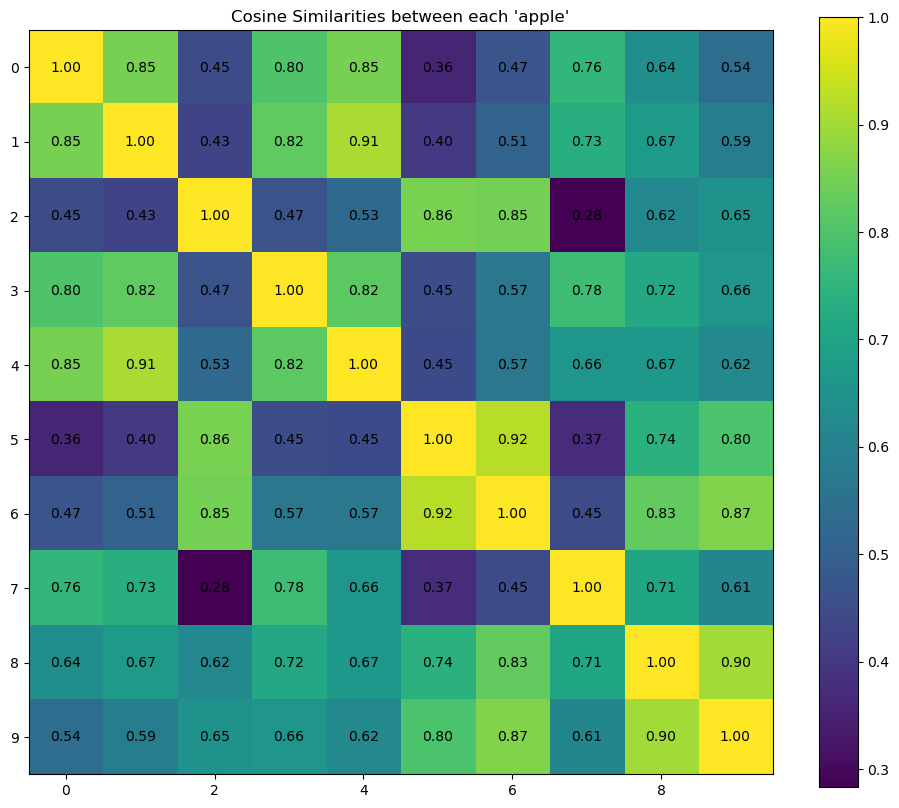

In [35]:
#embedding analysis between different 'apple's
import matplotlib.pyplot as plt

tokenized_sentences=[tokenizer(sentence,return_tensors='pt') for sentence in sentences]

outputs=[model(**tok_set) for tok_set in tokenized_sentences]
print(len(outputs[0].hidden_states))
def hidden_output(outputs,tokenized_sentences,select_word_index):
    hid_outs=[outputs[i].hidden_states[12][0] for i in range(len(outputs))]
    apple_hid_outs=[]
    for i in range(len(select_word_index)):
        select_token_index = tokenized_sentences[i].word_to_tokens(select_word_index[i]).start
       
        #print(tokenizer.decode(tokenized_sentences[i]['input_ids'][0][select_token_index]))
        apple_hid_outs.append(hid_outs[i][select_token_index,:])
    return apple_hid_outs

def pairwise_similarity(matric,inputs):
    matrix=[]
    for i in range(len(inputs)):
        mat=[]
        for j in range(len(inputs)):
            mat.append(matric(inputs[i],inputs[j]))
        matrix.append(mat)
    return torch.tensor(matrix)

METRIC=euclidean_distance
apple_hid_outs=hidden_output(outputs,tokenized_sentences,select_word_index)    
matrix=pairwise_similarity(METRIC,apple_hid_outs)
print(matrix)

#print(apple_hid_outs[0].shape)
#a = outputs[0].hidden_states[12][0]
#print(a.shape)
plt.rcParams['figure.figsize'] = [12, 10] 
plt.imshow(matrix.numpy())
plt.colorbar() 
plt.yticks(ticks=range(len(sentences)))
plt.title('Euclidean Distances between each \'apple\'') 
for (i,j), label in np.ndenumerate(matrix):
    plt.text(i, j, '{:.2f}'.format(label), ha='center', va='center') 
plt.show() 


METRIC=cosine_similarity
apple_hid_outs=hidden_output(outputs,tokenized_sentences,select_word_index)    
matrix=pairwise_similarity(METRIC,apple_hid_outs)
print(matrix)

plt.rcParams['figure.figsize'] = [12, 10]
plt.imshow(matrix.numpy()) 
plt.colorbar() 
plt.yticks(ticks=range(len(sentences))) 
plt.title('Cosine Similarities between each \'apple\'') 
for (i,j), label in np.ndenumerate(matrix): 
    plt.text(i, j, '{:.2f}'.format(label), ha='center', va='center')
plt.show() 

In [3]:
tokenizer1 = BertTokenizerFast.from_pretrained("/kaggle/input/hw9bert/hw9_bert/tokenizer1")
tokenizer2 = BertTokenizerFast.from_pretrained("/kaggle/input/hw9bert/hw9_bert/tokenizer2")
tokenizer3 = BertTokenizerFast.from_pretrained("/kaggle/input/hw9bert/hw9_bert/tokenizer3")
tokenizers = [tokenizer1, tokenizer2, tokenizer3]

contexts, questions, answers = [], [], []

# Question 1
contexts += ['Currently detention is one of the most common punishments in schools in the United States, the UK, Ireland, Singapore and other countries. \
            It requires the pupil to remain in school at a given time in the school day (such as lunch, recess or after school); or even to attend \
            school on a non-school day, e.g. "Saturday detention" held at some schools. During detention, students normally have to sit in a classroom \
            and do work, write lines or a punishment essay, or sit quietly.']
questions += ['What is a common punishment in the UK and Ireland?']
answers += ['detention']

# Question 2
contexts += ['Wolves are afraid of cats. Sheep are afraid of wolves. Mice are afraid of sheep. Gertrude is a mouse. Jessica is a mouse. \
            Emily is a wolf. Cats are afraid of sheep. Winona is a wolf.']
questions += ['What is Emily afraid of?']
answers += ['cats']

# Question 3
contexts += ["Nikola Tesla (Serbian Cyrillic: Никола Тесла; 10 July 1856 – 7 January 1943) was a Serbian American inventor, electrical engineer, \
            mechanical engineer, physicist, and futurist best known for his contributions to the design of the modern alternating current \
            (AC) electricity supply system."]
questions += ["In what year was Nikola Tesla born?"]
answers += ["1856"]



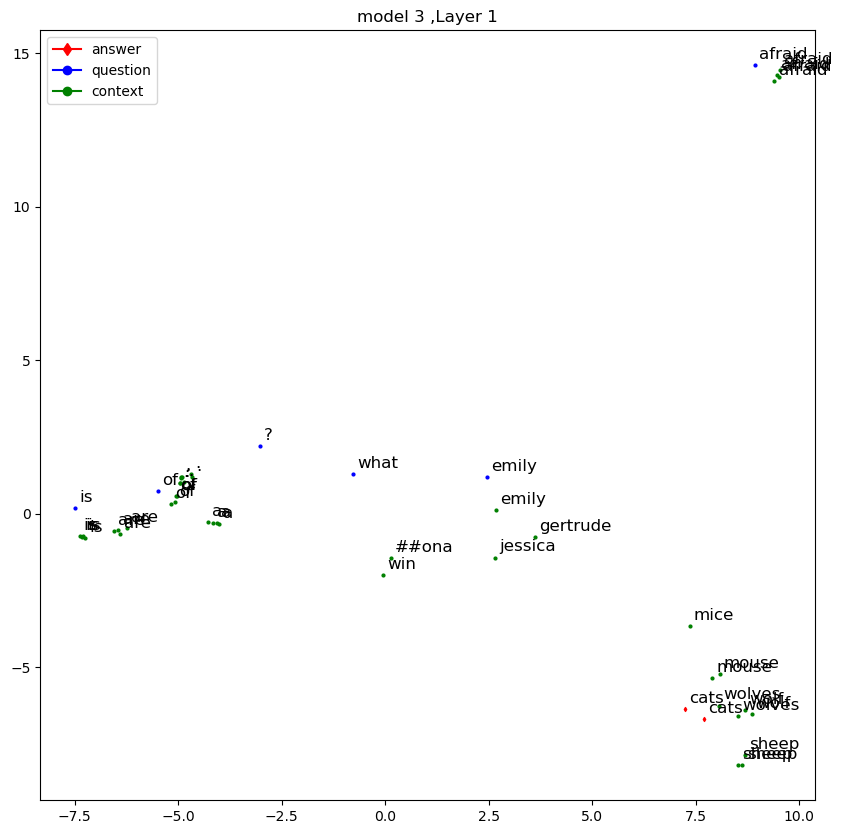

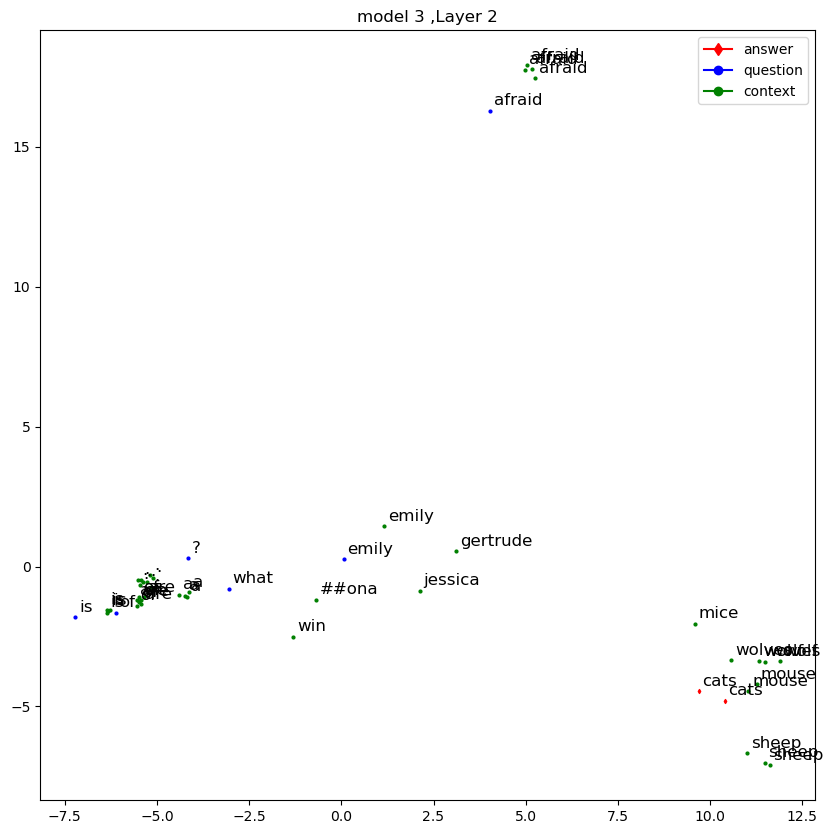

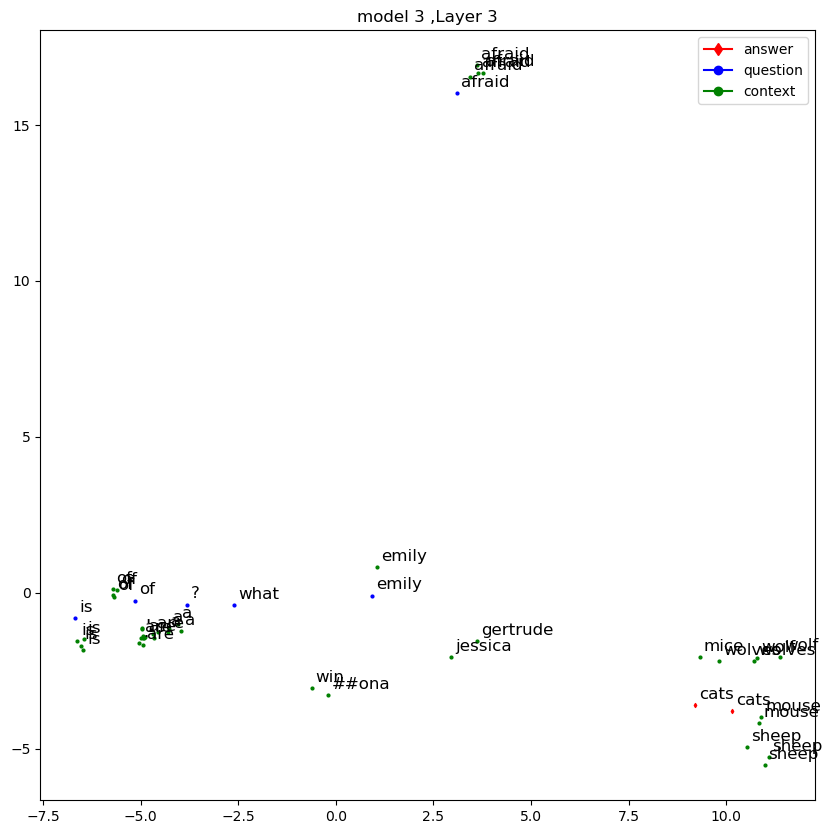

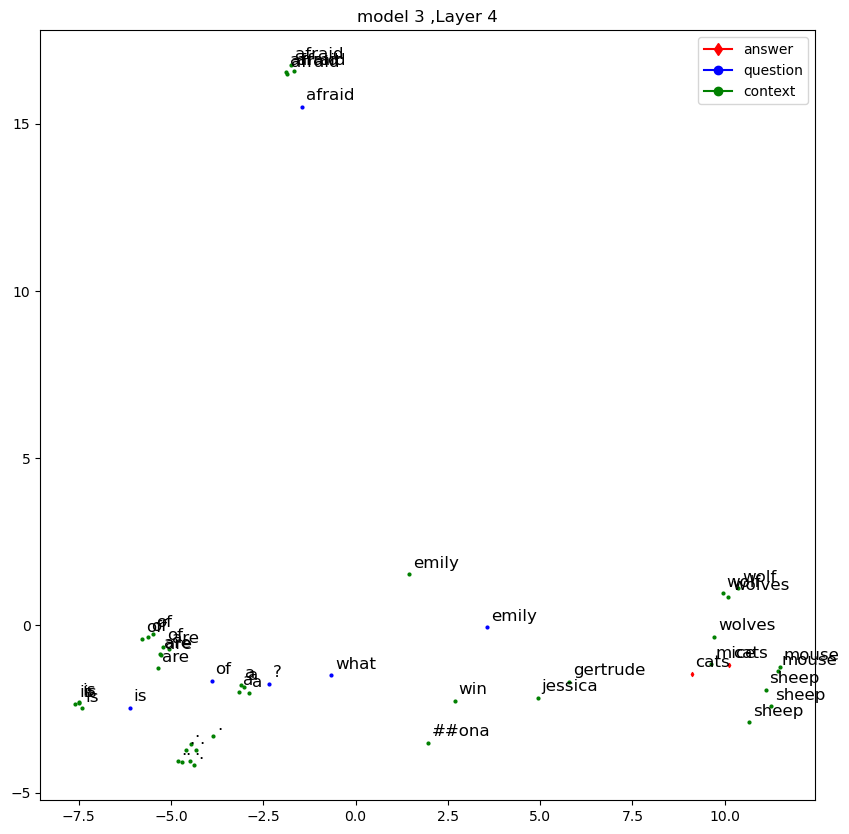

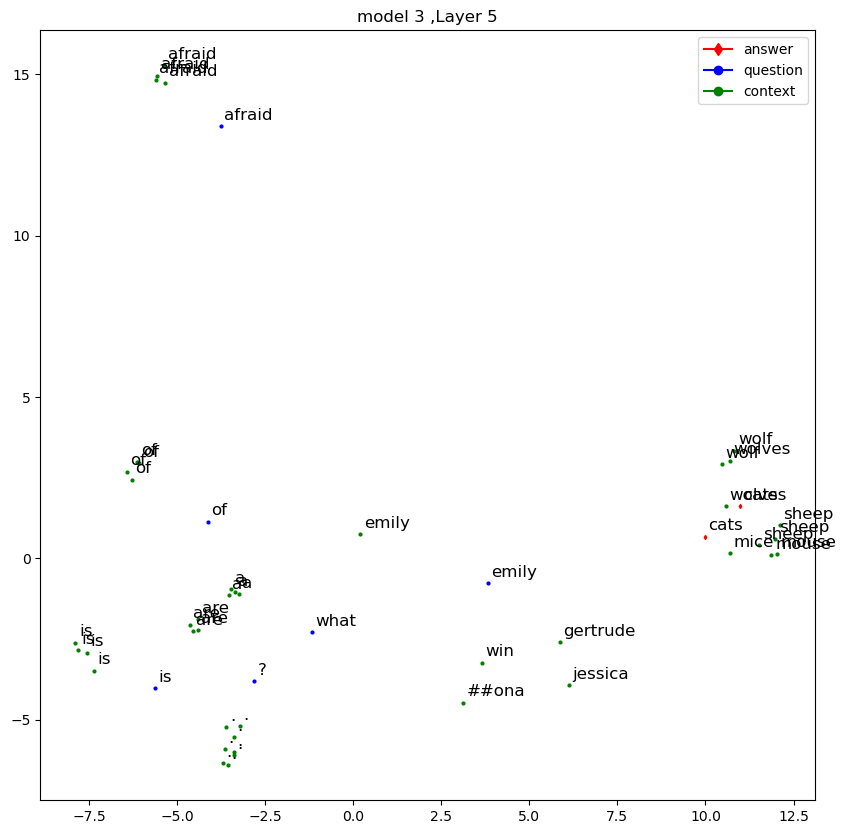

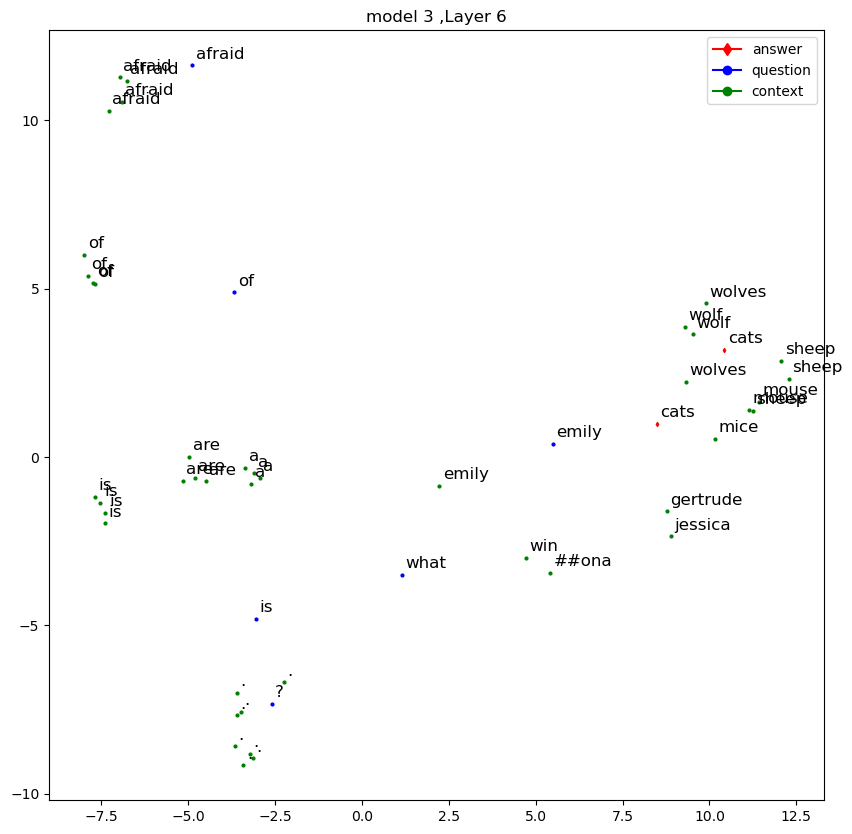

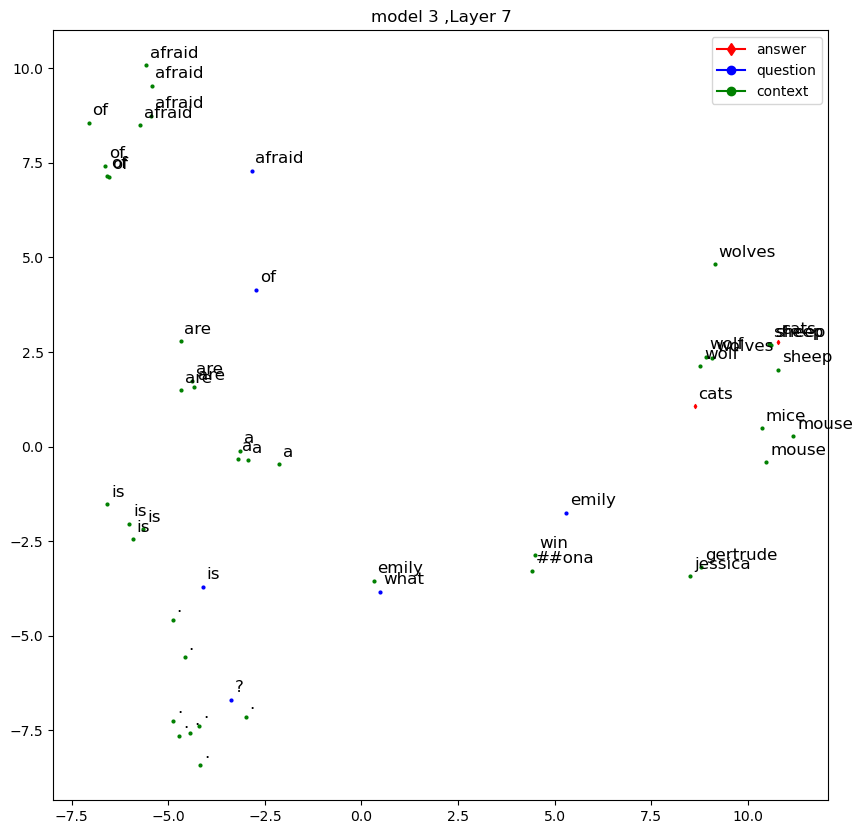

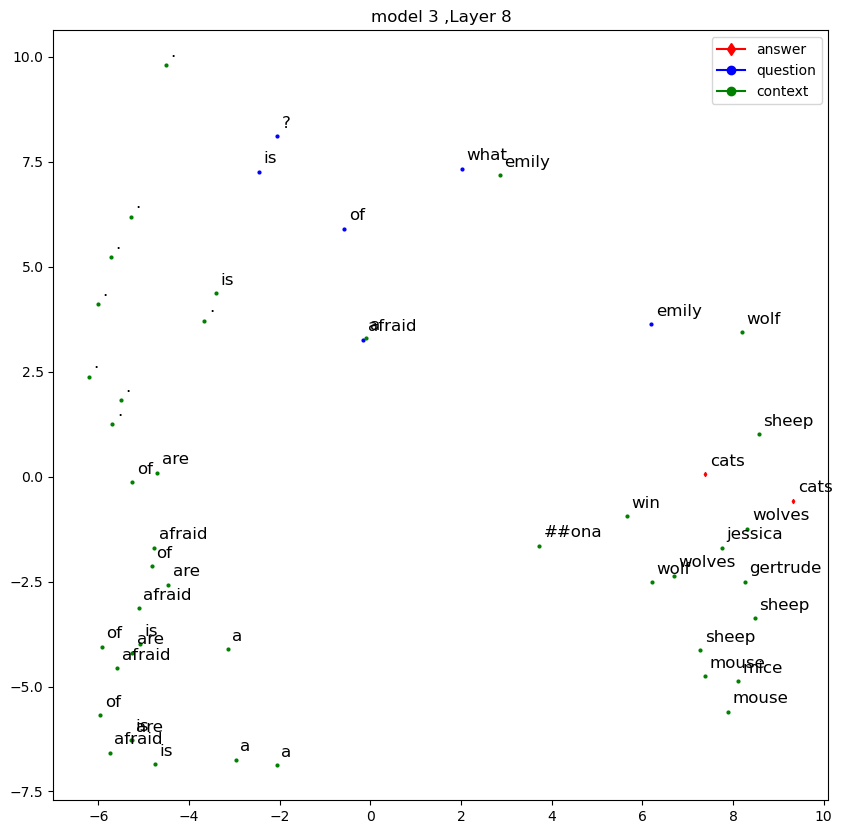

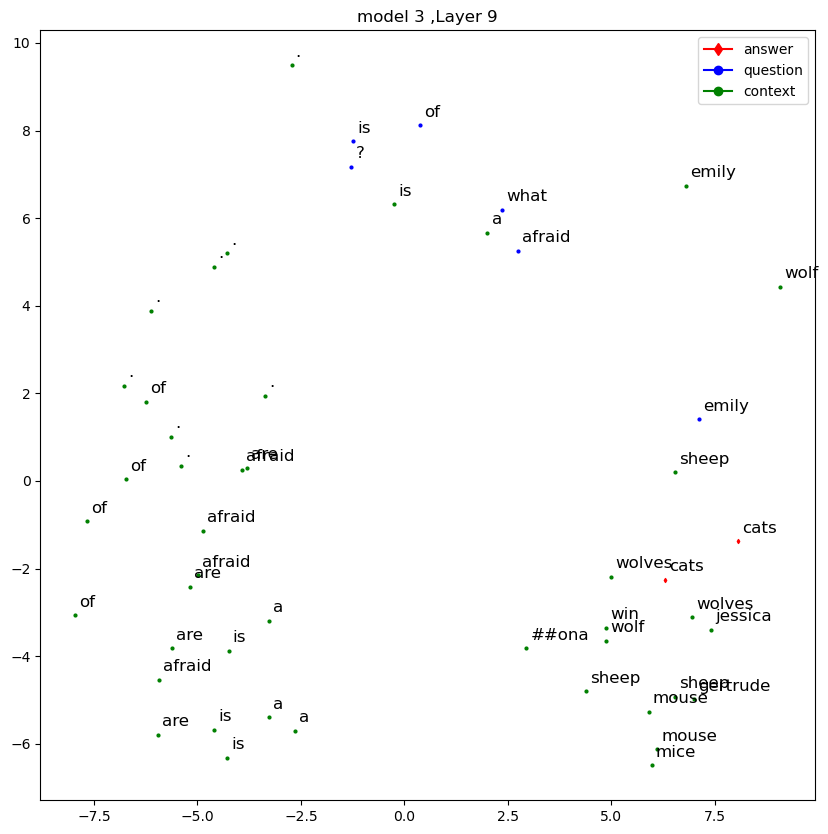

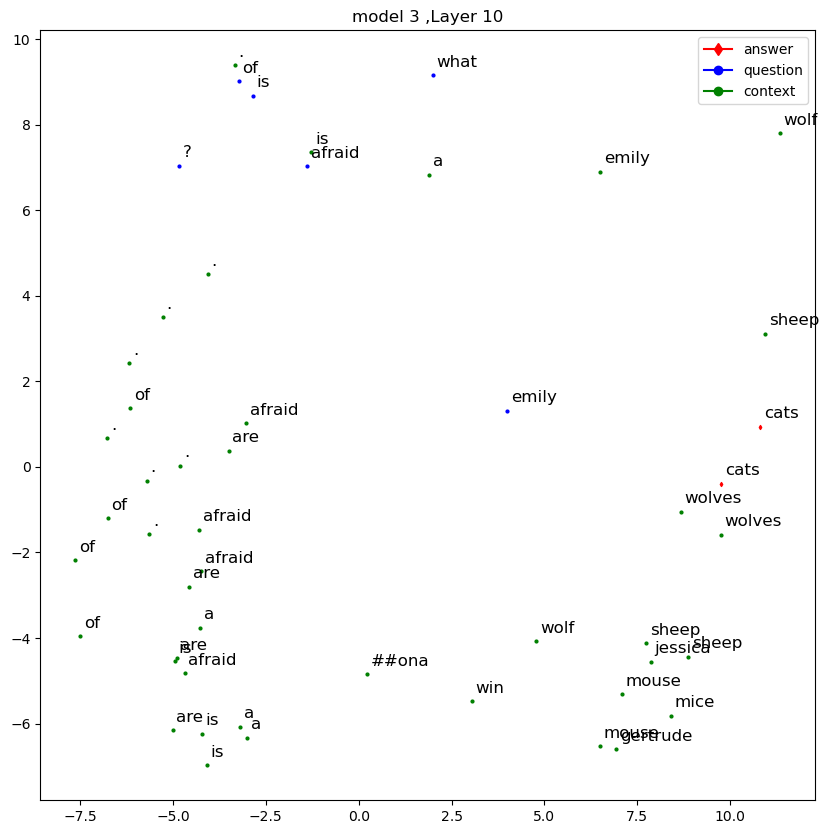

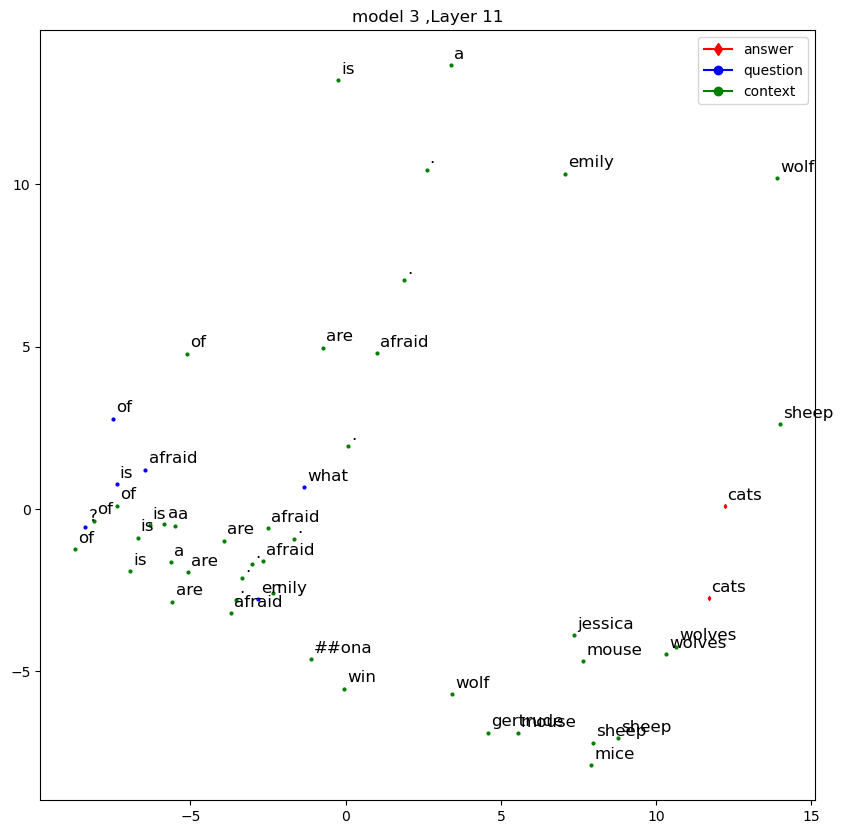

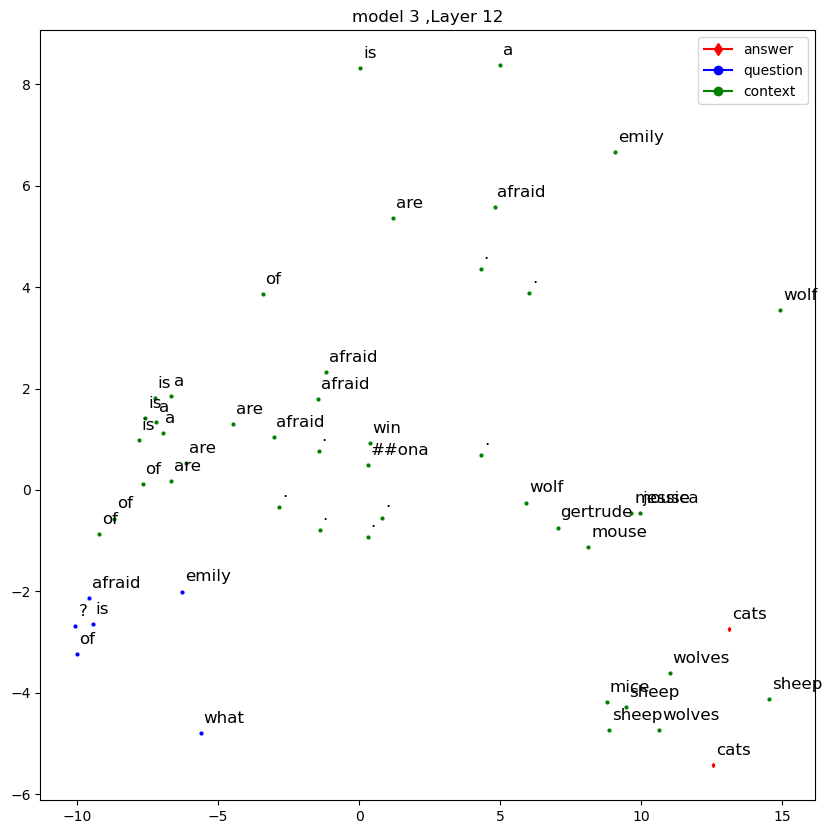

In [17]:
#embedding visualization of QA Bert
import matplotlib.pyplot as plt
def visualization(model_id,ques_id,tokenizers,contexts,questions,answers,s,e):
    inputs=tokenizers[model_id-1](questions[ques_id-1],contexts[ques_id-1], return_tensors='pt')
    ques_start,ques_end=1,torch.squeeze(inputs['input_ids'],dim=0).tolist().index(102)-1
    context_start,context_end=ques_end+2,len(torch.squeeze(inputs['input_ids'],dim=0))-2
    outputs_hidden_states = torch.load(f"/kaggle/input/hw9bert/hw9_bert/output/model{model_id}_q{ques_id}")
    for i,hidden_output in enumerate(outputs_hidden_states[s:e]):
        #hidden_output.shape:[1,length,768]
        hidden_output=torch.squeeze(hidden_output,dim=0)
        #reduced_embedding.shape:[length,2]
        reduced_embeddings = PCA(n_components=2, random_state=0).fit_transform(hidden_output)
        plt.figure(figsize=(10,10))
        for idx in range(len(torch.squeeze(inputs['input_ids'],dim=0))):
            x,y=reduced_embeddings[idx,0],reduced_embeddings[idx,1]
            word=tokenizers[model_id-1].decode(inputs['input_ids'][0][idx])
            if word==answers[ques_id-1]:
                plt.scatter(x,y,color='red',marker='d',s=4)
            elif ques_start<=idx<=ques_end:
                plt.scatter(x,y,color='blue',marker='o',s=4)
            elif context_start<=idx<=context_end:
                plt.scatter(x,y,color='green',marker='o',s=4)
            else:
                continue
            plt.text(x + 0.1, y + 0.2, word, fontsize=12) # Plot word next to its point
        
        
        plt.plot([], label='answer', color='red', marker='d')  
        plt.plot([], label='question', color='blue', marker='o')
        plt.plot([], label='context', color='green', marker='o')
        plt.legend(loc='best') # Display the area describing the elements in the plot
        plt.title('model '+str(model_id)+' ,Layer '+str(s+i)) # Add title to the plot
        plt.show() # Show the plot        
        
    
#visualization(1,2,tokenizers,contexts,questions,answers,1,13)
#visualization(2,3,tokenizers,contexts,questions,answers,1,13)
visualization(3,2,tokenizers,contexts,questions,answers,1,13)